# 预训练BERT
:label:`sec_bert-pretraining`

利用 :numref:`sec_bert`中实现的BERT模型和 :numref:`sec_bert-dataset`中从WikiText-2数据集生成的预训练样本，我们将在本节中在WikiText-2数据集上对BERT进行预训练。


In [31]:
import os
import random
import torch
from torch import nn
from d2l import torch as d2l
from datasets import load_dataset

In [32]:
import platform
def load_wikitext_2():
    # 从 Hugging Face 下载 wikitext-2 数据集
    # 数据集大小：12.1 MB
    if platform.system() == "Darwin":
        cache_dir = "/Users/usst_ziyi/Programs/AI/d2l-pytorch/data"
    else:
        cache_dir = "D:\Github\AI\d2l-pytorch\data"
    wikitext2 = load_dataset("wikitext", name="wikitext-2-v1", cache_dir=cache_dir)
    # 拆分数据集
    train_iter = wikitext2["train"]
    valid_iter = wikitext2["validation"]
    test_iter = wikitext2["test"]
    return train_iter, valid_iter, test_iter

In [33]:
def _read_wiki():
    train_iter, _, _ = load_wikitext_2()
    # 将数据集转换为列表
    # lines:List[Str]
    lines = [line['text'] for line in train_iter]
    # paragraphs:List[List[Str]]
    # 只有当你对字符串主动调用会返回列表的方法时，才会产生子列表,比如这里的split()
    paragraphs = [line.strip().lower().split(' . ') for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs
    # paragraphs:List[List[Str]]

In [34]:
paragraphs = _read_wiki()
# for 行内所有句子 in 行
for paragraph in paragraphs[:10]:
    print(paragraph)

['" we will not give the portrait of valentin alkan from the rear , as in some photographs we have seen', 'his intelligent and original <unk> deserves to be taken in profile or head @-@ on', 'the head is strong ; the deep forehead is that of a thinker ; the mouth large and smiling , the nose regular ; the years have <unk> the beard and hair ... the gaze fine , a little mocking', 'his <unk> walk , his puritan <unk> , give him the look of an anglican minister or a rabbi – for which he has the abilities', '"']
["having damaged his knee ligaments during the play @-@ off semi @-@ final , cresswell missed the start of the 2006 – 07 season , making his first appearance in leeds ' 4 – 0 home defeat to stoke city on 14 october 2006", "however , he sustained a knee injury in november 2006 , after scoring his first goal of the campaign in leeds ' 3 – 0 home win over colchester united on 11 november", 'his return from injury came as a 68th @-@ minute substitute in a 2 – 1 victory at home to crysta

In [35]:
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    num_workers = d2l.get_dataloader_workers()
    # paragraphs:List[List[Str]]
    paragraphs = _read_wiki()
    # train_set: all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels
    train_set = d2l._WikiTextDataset(paragraphs, max_len)
    # train_iter: all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。批量大小是512，BERT输入序列的最大长度是64。注意，在原始BERT模型中，最大长度是512。


In [36]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

## 预训练BERT

原始BERT :cite:`Devlin.Chang.Lee.ea.2018`有两个不同模型尺寸的版本。基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。


In [108]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss(reduction='none') # 默认是mean

在定义训练代码实现之前，我们定义了一个辅助函数`_get_batch_loss_bert`。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。


In [ ]:
# tokens_X(B,Q):输入的词元序列
# segments_X(B,Q):输入的段落序列
# valid_lens_x(B):有效长度序列
# pred_positions_X(B,C):被掩蔽位置序列
# mlm_weights_X(B,C):被掩蔽位置的权重序列
# mlm_Y(B,C):被掩蔽位置的标签序列
# nsp_y(B):下一句是否是下一句的标签序列
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    # 1.BERTModel前向传播
    # encoded_X(B,Q,H)
    # mlm_Y_hat(B,C,V):表示每个被掩蔽位置的词(隐状态)对词表中每个词的预测得分
    # nsp_Y_hat(B,2):表示下一句是否是下一句的预测得分
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)
    
    # 2.计算遮蔽语言模型损失
    # 第一步：计算每个掩蔽位置的交叉熵损失
    # CrossEntropyLoss logits shape: (N, C)，其中 N 是样本数，C 是类别数（这里 C = vocab_size）
    # CrossEntropyLoss target shape: (N,)，每个元素是类别索引
    # mlm_Y_hat(B,C,V)->(B*C,V)
    # mlm_Y(B,C)->(B*C,)
    # mlm_l_raw(B*C,):每个掩蔽位置的交叉熵损失
    mlm_l_raw = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1))
    # 第二步：乘以对应位置的权重
    # mlm_l_raw(B*C,):每个掩蔽位置的交叉熵损失
    # mlm_weights_X(B,C)->(B*C,)
    # mlm_l(B*C,):每个掩蔽位置的交叉熵损失,此时后面无效位已经变为0
    mlm_l = mlm_l_raw * mlm_weights_X.reshape(-1)
    # 第三步：mean
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)

    # 3.计算下一句子预测任务的损失
    # CrossEntropyLoss logits shape: (N, C)，其中 N 是样本数，C 是类别数（这里 C = 2）
    # CrossEntropyLoss target shape: (N,)，每个元素是类别索引
    # nsp_Y_hat(B,2)->(B,2)
    # nsp_y(B,)->(B,)
    # nsp_l(B,)->(1,):每个样本的下一句子预测任务的交叉熵损失,再mean()得到标量
    nsp_l = loss(nsp_Y_hat, nsp_y).mean()

    # BERT总损失=遮蔽语言模型损失+下一句子预测任务损失
    # l(1,):标量
    l = mlm_l + nsp_l
    # 都是标量
    return mlm_l, nsp_l, l

通过调用上述两个辅助函数，下面的`train_bert`函数定义了在WikiText-2（`train_iter`）数据集上预训练BERT（`net`）的过程。训练BERT可能需要很长时间。以下函数的输入`num_steps`指定了训练的迭代步数，而不是像`train_ch13`函数那样指定训练的轮数（参见 :numref:`sec_image_augmentation`）。


In [110]:
# num_steps: 表示1个epoch中，训练多少个batch
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    # 多GPU训练
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss = loss

    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps], legend=['mlm', 'nsp'])
    metric = d2l.Accumulator(4)
    num_steps_reached = False

    while step < num_steps and not num_steps_reached:
        # 取出一个批次
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y = mlm_Y.to(devices[0])
            nsp_y = nsp_y.to(devices[0])

            # all_token_ids,           # [B, Q]
            # all_segments,            # [B, Q]
            # valid_lens,              # [B]
            # all_pred_positions,      # [B, C]
            # all_mlm_weights,         # [B, C]
            # all_mlm_labels_ids,      # [B, C]
            # nsp_labels               # [B]


            
            optimizer.zero_grad()
            timer.start()
            # 都是标量
            mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            optimizer.step()


            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, ' f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on ' f'{str(devices)}')

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。


MLM loss 6.981, NSP loss 0.704
266.7 sentence pairs/sec on [device(type='cpu')]


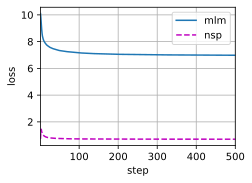

In [111]:
train_bert(train_iter, net, loss, len(vocab), devices, 500)

## 用BERT表示文本

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回`tokens_a`和`tokens_b`中所有词元的BERT（`net`）表示。


In [141]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    # tokens:['<cls>'] + tokens_a + ['<sep>']
    # segments:List(int)
    # Q = len(tokens_a)+2
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    # token_ids:Tensor(Q)->(1,Q)
    # 测试的时候，没有整理数据集，这里临时创造测试数据
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    print(token_ids)
    # segments:Tensor(Q)->(1,Q)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    print(segments)
    # len(tokens) = len(token_a)+2
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    print(valid_len)
    # encoded_X(B,Q,H)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑“a crane is flying”这句话。回想一下 :numref:`subsec_bert_input_rep`中讨论的BERT的输入表示。插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，BERT输入序列的长度为6。因为零是“&lt;cls&gt;”词元，`encoded_text[:, 0, :]`是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。


In [210]:
tokens_a = ['a', 'crane', 'is', 'flying']
# 禁用梯度，仅做推理
net.eval()
with torch.no_grad():
    # encoded_text(1,Q,H)
    encoded_text = get_bert_encoding(net, tokens_a)
print(encoded_text.shape)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
print(encoded_text.shape)
print(encoded_text_cls.shape)
# 当前词元crane的上下文隐状态
print(encoded_text_crane[0][:3])


tensor([[   3,   11, 7461,   23, 1555,    4]])
tensor([[0, 0, 0, 0, 0, 0]])
tensor([6])
torch.Size([1, 6, 128])
torch.Size([1, 6, 128])
torch.Size([1, 128])
tensor([-0.5656, -0.2278, -0.7246])


现在考虑一个句子“a crane driver came”和“he just left”。类似地，`encoded_pair[:, 0, :]`是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。


In [211]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
# 禁用梯度，仅做推理
net.eval()
with torch.no_grad():
    # encoded_pair(1,Q,H)
    encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just', 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
print(encoded_pair.shape)
print(encoded_pair_cls.shape)
print(encoded_pair_crane[0][:3])


tensor([[   3,   11, 7461, 3511,  326,    4,   30,  244,  253,    4]])
tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])
tensor([10])
torch.Size([1, 10, 128])
torch.Size([1, 128])
tensor([-0.5655, -0.2280, -0.7251])


在 :numref:`chap_nlp_app`中，我们将为下游自然语言处理应用微调预训练的BERT模型。

## 小结

* 原始的BERT有两个版本，其中基本模型有1.1亿个参数，大模型有3.4亿个参数。
* 在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。
* 在实验中，同一个词元在不同的上下文中具有不同的BERT表示。这支持BERT表示是上下文敏感的。

## 练习

1. 在实验中，我们可以看到遮蔽语言模型损失明显高于下一句预测损失。为什么？
2. 将BERT输入序列的最大长度设置为512（与原始BERT模型相同）。使用原始BERT模型的配置，如$\text{BERT}_{\text{LARGE}}$。运行此部分时是否遇到错误？为什么？


[Discussions](https://discuss.d2l.ai/t/5743)
